In [2]:
# !pip install 'zarr<3'
# !pip install timm


In [3]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


## Data Loading

Using device: cuda

📁 Loading H&E image...
   Image shape: (512, 512, 3)

🎨 Loading GAN generator...
   ✓ GAN loaded

🔄 Generating synthetic MIF from H&E...
   Synthetic MIF shape: (512, 512, 2)

📦 Loading VitaminPSyn model...
Building H&E encoder with DINOv2-base
Building Synthetic MIF encoder with DINOv2-base
Building shared encoder with DINOv2-base
✓ VitaminPSyn initialized with base backbone
  Embed dim: 768 | Decoder dims: [768, 384, 192, 96]
   ✓ VitaminPSyn loaded

🧠 Running VitaminPSyn inference...
   ✓ Inference complete

📊 Visualizing results...


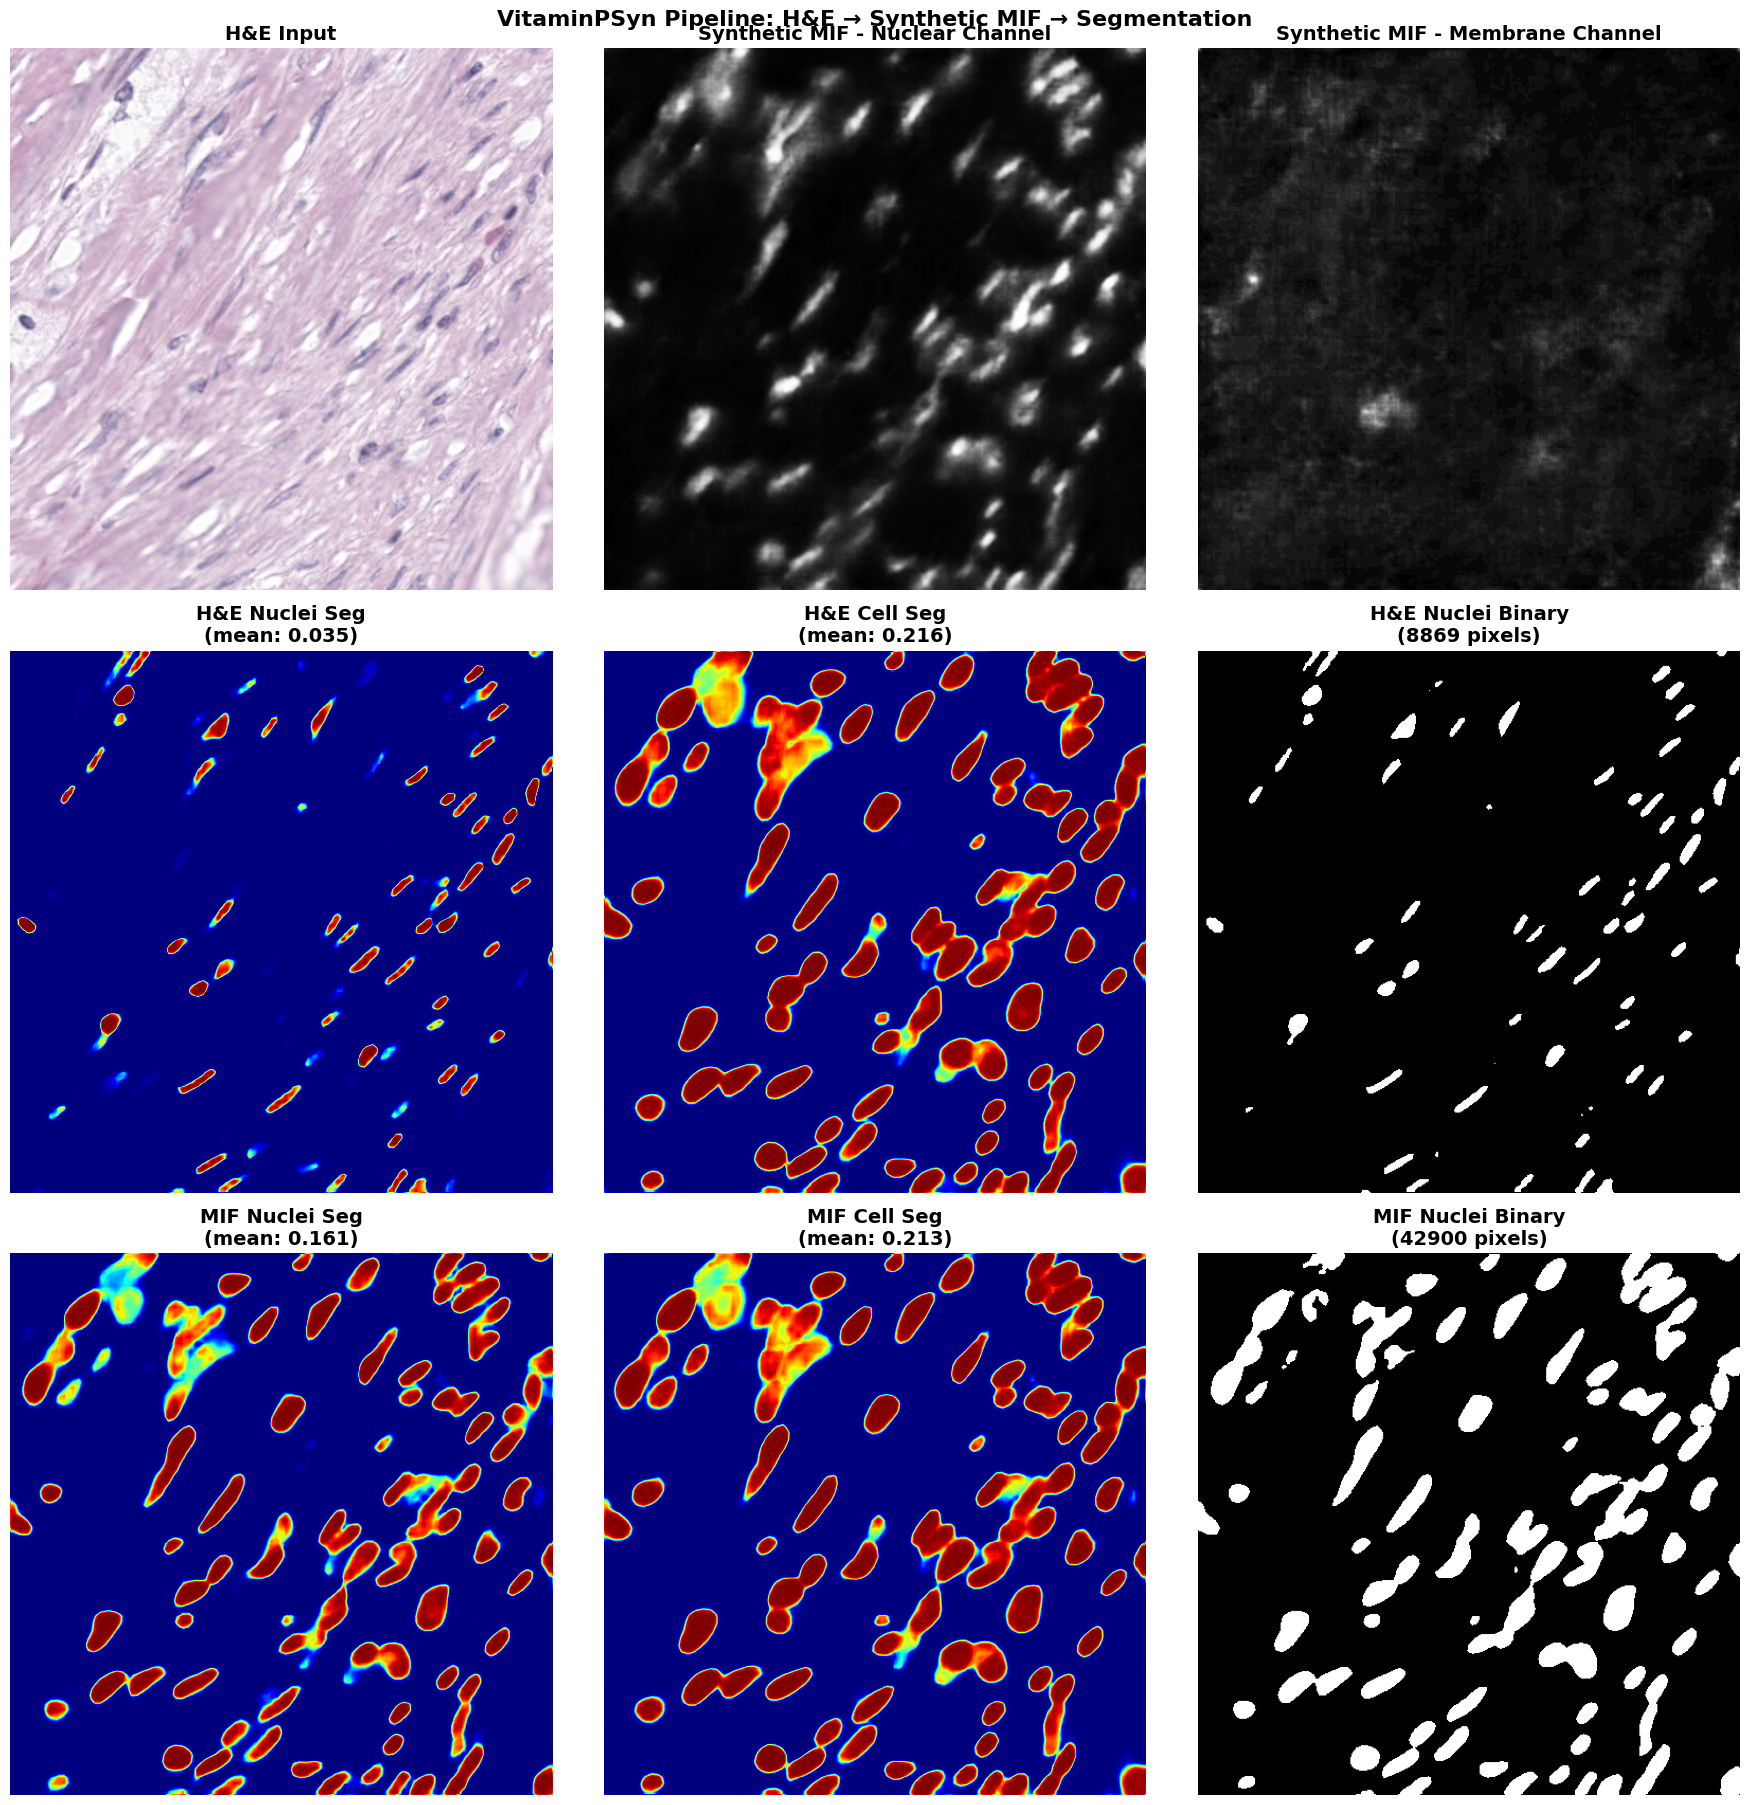


PREDICTION STATISTICS

H&E Nuclei:
  Mean prob:    0.0350
  Max prob:     1.0000
  Pixels > 0.5: 8,869 / 262,144 (3.38%)

H&E Cell:
  Mean prob:    0.2156
  Max prob:     0.9999
  Pixels > 0.5: 58,475 / 262,144 (22.31%)

MIF Nuclei:
  Mean prob:    0.1612
  Max prob:     0.9999
  Pixels > 0.5: 42,900 / 262,144 (16.37%)

MIF Cell:
  Mean prob:    0.2127
  Max prob:     0.9998
  Pixels > 0.5: 57,899 / 262,144 (22.09%)

✅ Verification complete!

🔍 SANITY CHECKS:
✓  H&E nuclei predictions look reasonable (mean = 0.0350)
✓  MIF nuclei predictions look reasonable (mean = 0.1612)
✓  Synthetic MIF looks reasonable (mean = 0.0696)
✓  H&E nuclei seg in valid range [0, 1]




In [6]:
"""
Test VitaminPSyn on single H&E image with visualization
Verify the pipeline: H&E → GAN → Synthetic MIF → VitaminPSyn → Results
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from vitaminp import VitaminPSyn, SimplePreprocessing
from vitaminp.gan import Pix2PixGenerator, GANPreprocessing

# ========================================================================
# SETUP
# ========================================================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load image
print("\n📁 Loading H&E image...")
he_img_path = 'test_images/CRC31-he_chunk_14.png'
he_img = np.array(Image.open(he_img_path))
print(f"   Image shape: {he_img.shape}")

# Normalize to [0, 1]
if he_img.max() > 1.0:
    he_img = he_img.astype(np.float32) / 255.0

# ========================================================================
# STEP 1: LOAD GAN GENERATOR
# ========================================================================
print("\n🎨 Loading GAN generator...")
gan_generator = Pix2PixGenerator(in_channels=3, out_channels=2).to(device)
gan_checkpoint = torch.load('checkpoints/pix2pix_he_to_mif_final.pth', map_location=device)
gan_generator.load_state_dict(gan_checkpoint['generator_state_dict'])
gan_generator.eval()
print("   ✓ GAN loaded")

gan_preprocessor = GANPreprocessing()

# ========================================================================
# STEP 2: GENERATE SYNTHETIC MIF
# ========================================================================
print("\n🔄 Generating synthetic MIF from H&E...")

# Resize to 256x256 for GAN (it was trained on this size)
from PIL import Image as PILImage
he_img_256 = np.array(PILImage.fromarray((he_img * 255).astype(np.uint8)).resize((256, 256)))
he_img_256 = he_img_256.astype(np.float32) / 255.0

# Convert to tensor
he_tensor = torch.from_numpy(he_img_256).permute(2, 0, 1).unsqueeze(0).to(device)

# GAN preprocessing
he_norm = gan_preprocessor.percentile_normalize(he_tensor)
he_gan_input = gan_preprocessor.to_gan_range(he_norm)

# Generate
with torch.no_grad():
    fake_mif = gan_generator(he_gan_input)

# Convert back
fake_mif_01 = gan_preprocessor.from_gan_range(fake_mif)

# Resize back to 512x512
fake_mif_np = fake_mif_01[0].permute(1, 2, 0).cpu().numpy()  # (256, 256, 2)
fake_mif_512 = np.array(PILImage.fromarray((fake_mif_np[:, :, 0] * 255).astype(np.uint8)).resize((512, 512))).astype(np.float32) / 255.0
fake_mif_512 = np.stack([
    fake_mif_512,
    np.array(PILImage.fromarray((fake_mif_np[:, :, 1] * 255).astype(np.uint8)).resize((512, 512))).astype(np.float32) / 255.0
], axis=-1)

print(f"   Synthetic MIF shape: {fake_mif_512.shape}")

# ========================================================================
# STEP 3: LOAD VITAMINPSYN MODEL
# ========================================================================
print("\n📦 Loading VitaminPSyn model...")
model = VitaminPSyn(model_size='base', dropout_rate=0.3).to(device)
model.load_state_dict(torch.load("checkpoints/vitamin_p_syn_base_fold12_best.pth", map_location=device))
model.eval()
print("   ✓ VitaminPSyn loaded")

preprocessor = SimplePreprocessing()

# ========================================================================
# STEP 4: RUN VITAMINPSYN INFERENCE
# ========================================================================
print("\n🧠 Running VitaminPSyn inference...")

# Prepare H&E tensor (512, 512, 3) -> (1, 3, 512, 512)
he_tensor_full = torch.from_numpy(he_img).permute(2, 0, 1).unsqueeze(0).to(device)

# Prepare synthetic MIF tensor (512, 512, 2) -> (1, 2, 512, 512)
mif_tensor = torch.from_numpy(fake_mif_512).permute(2, 0, 1).unsqueeze(0).to(device)

# Normalize
he_tensor_full = preprocessor.percentile_normalize(he_tensor_full)
mif_tensor = preprocessor.percentile_normalize(mif_tensor)

# Run model
with torch.no_grad():
    outputs = model(he_tensor_full, mif_tensor)

# Extract predictions
he_nuclei_seg = outputs['he_nuclei_seg'][0, 0].cpu().numpy()
he_cell_seg = outputs['he_cell_seg'][0, 0].cpu().numpy()
mif_nuclei_seg = outputs['mif_nuclei_seg'][0, 0].cpu().numpy()
mif_cell_seg = outputs['mif_cell_seg'][0, 0].cpu().numpy()

print("   ✓ Inference complete")

# ========================================================================
# STEP 5: VISUALIZE RESULTS
# ========================================================================
print("\n📊 Visualizing results...")

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Row 1: Input images
axes[0, 0].imshow(he_img)
axes[0, 0].set_title('H&E Input', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(fake_mif_512[:, :, 0], cmap='gray')
axes[0, 1].set_title('Synthetic MIF - Nuclear Channel', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(fake_mif_512[:, :, 1], cmap='gray')
axes[0, 2].set_title('Synthetic MIF - Membrane Channel', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Row 2: H&E predictions
axes[1, 0].imshow(he_nuclei_seg, cmap='jet', vmin=0, vmax=1)
axes[1, 0].set_title(f'H&E Nuclei Seg\n(mean: {he_nuclei_seg.mean():.3f})', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(he_cell_seg, cmap='jet', vmin=0, vmax=1)
axes[1, 1].set_title(f'H&E Cell Seg\n(mean: {he_cell_seg.mean():.3f})', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(he_nuclei_seg > 0.5, cmap='gray')
axes[1, 2].set_title(f'H&E Nuclei Binary\n({(he_nuclei_seg > 0.5).sum()} pixels)', fontsize=14, fontweight='bold')
axes[1, 2].axis('off')

# Row 3: MIF predictions
axes[2, 0].imshow(mif_nuclei_seg, cmap='jet', vmin=0, vmax=1)
axes[2, 0].set_title(f'MIF Nuclei Seg\n(mean: {mif_nuclei_seg.mean():.3f})', fontsize=14, fontweight='bold')
axes[2, 0].axis('off')

axes[2, 1].imshow(mif_cell_seg, cmap='jet', vmin=0, vmax=1)
axes[2, 1].set_title(f'MIF Cell Seg\n(mean: {mif_cell_seg.mean():.3f})', fontsize=14, fontweight='bold')
axes[2, 1].axis('off')

axes[2, 2].imshow(mif_nuclei_seg > 0.5, cmap='gray')
axes[2, 2].set_title(f'MIF Nuclei Binary\n({(mif_nuclei_seg > 0.5).sum()} pixels)', fontsize=14, fontweight='bold')
axes[2, 2].axis('off')

plt.tight_layout()
plt.suptitle('VitaminPSyn Pipeline: H&E → Synthetic MIF → Segmentation', 
             fontsize=16, fontweight='bold', y=1.00)
plt.show()

# ========================================================================
# STATISTICS
# ========================================================================
print("\n" + "="*60)
print("PREDICTION STATISTICS")
print("="*60)
print(f"\nH&E Nuclei:")
print(f"  Mean prob:    {he_nuclei_seg.mean():.4f}")
print(f"  Max prob:     {he_nuclei_seg.max():.4f}")
print(f"  Pixels > 0.5: {(he_nuclei_seg > 0.5).sum():,} / {he_nuclei_seg.size:,} ({(he_nuclei_seg > 0.5).sum() / he_nuclei_seg.size * 100:.2f}%)")

print(f"\nH&E Cell:")
print(f"  Mean prob:    {he_cell_seg.mean():.4f}")
print(f"  Max prob:     {he_cell_seg.max():.4f}")
print(f"  Pixels > 0.5: {(he_cell_seg > 0.5).sum():,} / {he_cell_seg.size:,} ({(he_cell_seg > 0.5).sum() / he_cell_seg.size * 100:.2f}%)")

print(f"\nMIF Nuclei:")
print(f"  Mean prob:    {mif_nuclei_seg.mean():.4f}")
print(f"  Max prob:     {mif_nuclei_seg.max():.4f}")
print(f"  Pixels > 0.5: {(mif_nuclei_seg > 0.5).sum():,} / {mif_nuclei_seg.size:,} ({(mif_nuclei_seg > 0.5).sum() / mif_nuclei_seg.size * 100:.2f}%)")

print(f"\nMIF Cell:")
print(f"  Mean prob:    {mif_cell_seg.mean():.4f}")
print(f"  Max prob:     {mif_cell_seg.max():.4f}")
print(f"  Pixels > 0.5: {(mif_cell_seg > 0.5).sum():,} / {mif_cell_seg.size:,} ({(mif_cell_seg > 0.5).sum() / mif_cell_seg.size * 100:.2f}%)")

print("\n" + "="*60)
print("✅ Verification complete!")
print("="*60)

# ========================================================================
# SANITY CHECKS
# ========================================================================
print("\n🔍 SANITY CHECKS:")

# Check 1: Are predictions reasonable?
if he_nuclei_seg.mean() < 0.01:
    print("⚠️  WARNING: H&E nuclei predictions very low (mean < 0.01)")
else:
    print(f"✓  H&E nuclei predictions look reasonable (mean = {he_nuclei_seg.mean():.4f})")

if mif_nuclei_seg.mean() < 0.01:
    print("⚠️  WARNING: MIF nuclei predictions very low (mean < 0.01)")
else:
    print(f"✓  MIF nuclei predictions look reasonable (mean = {mif_nuclei_seg.mean():.4f})")

# Check 2: Synthetic MIF quality
if fake_mif_512.mean() < 0.01 or fake_mif_512.mean() > 0.99:
    print(f"⚠️  WARNING: Synthetic MIF might be degenerate (mean = {fake_mif_512.mean():.4f})")
else:
    print(f"✓  Synthetic MIF looks reasonable (mean = {fake_mif_512.mean():.4f})")

# Check 3: Model outputs in valid range
if he_nuclei_seg.min() < 0 or he_nuclei_seg.max() > 1:
    print(f"⚠️  WARNING: H&E nuclei seg out of range [{he_nuclei_seg.min():.2f}, {he_nuclei_seg.max():.2f}]")
else:
    print(f"✓  H&E nuclei seg in valid range [0, 1]")

print("\n")